<a href="https://colab.research.google.com/github/wangyiiing/MPA-MLF_Lab/blob/main/ML_finalproject_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
#Mount Google Drive and list data folder
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/ML_Project/MPA-MLF_DATA_NEW

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
label_train.csv  submission_v2.csv  submission_v8.csv  test_format.csv
submission.csv	 submission_v3.csv  Test	       Train


In [58]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# 1. set up root path using google drive
ROOT_PATH = '/content/drive/MyDrive/ML_Project/MPA-MLF_DATA_NEW'

# 2. Define sub‑directories and file paths
TRAIN_DIR  = os.path.join(ROOT_PATH, 'Train')
TEST_DIR   = os.path.join(ROOT_PATH, 'Test')
LABEL_CSV  = os.path.join(ROOT_PATH, 'label_train.csv')
FORMAT_CSV = os.path.join(ROOT_PATH, 'test_format.csv')

# 3. Check file counts and existence
print('Train folder exists?        ', os.path.isdir(TRAIN_DIR))
print('Number of files in Train:   ', len(os.listdir(TRAIN_DIR)) if os.path.isdir(TRAIN_DIR) else '—')
print('Test folder exists?         ', os.path.isdir(TEST_DIR))
print('Number of files in Test:    ', len(os.listdir(TEST_DIR)) if os.path.isdir(TEST_DIR) else '—')
print('label_train.csv exists?     ', os.path.isfile(LABEL_CSV))
print('test_format.csv exists?     ', os.path.isfile(FORMAT_CSV))

# 4. Preview the first 5 rows of the label CSV (if it exists)
if os.path.isfile(LABEL_CSV):
    df = pd.read_csv(LABEL_CSV)
    print('\nFirst 5 rows of label_train.csv:')
    print(df.head())
else:
    print('\nCould not locate label_train.csv.')

Train folder exists?         True
Number of files in Train:    1491
Test folder exists?          True
Number of files in Test:     120
label_train.csv exists?      True
test_format.csv exists?      True

First 5 rows of label_train.csv:
   ID  target
0   0       0
1   1       0
2   2       0
3   3       0
4   4       0


In [59]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models

def normalize(arr):
    return (arr - arr.mean()) / (arr.std() + 1e-6)

labels_df = pd.read_csv(LABEL_CSV)
labels_df['filepath'] = labels_df['ID'].astype(str).apply(lambda x: os.path.join(TRAIN_DIR, f"{x}.npy"))

# Load and preprocess all training samples into memory
x_data = []
y_data = []

for _, row in labels_df.iterrows():
    x = np.load(row['filepath'])               # (72, 48)
    x = normalize(x)
    x = np.expand_dims(x, axis=-1)             # → (72, 48, 1)
    x_data.append(x)
    y_data.append(row['target'])

x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.int32)


In [60]:
from sklearn.model_selection import train_test_split

# Split data 80/20, with a fixed seed for reproducibility
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(16)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(16)



In [78]:
#Define CNN model

def build_model(input_shape=(72, 48, 1), num_classes=3):
    """
    Build a simple convolutional neural network.

    input_shape: (height, width, channels)
    num_classes: number of output classes
    """
    model = models.Sequential([
        # First conv layer: 16 filters of size 3x3, ReLU activation
        layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2),  # 72x48 → 36x24

        # Second conv block
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(2),  # 36x24 → 18x12

        # Third conv block
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(2),  #  18x12 → 9x6

        # Flatten feature maps to 1D
        layers.Flatten(),
        # Fully connected layer
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

#Compile and inspect model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

    model.summary()


In [79]:
#Train model

# Instantiate the model
model = build_model()

# Fit the model on the training set, validate on the validation set
history = model.fit(train_ds, validation_data=val_ds, epochs=30, verbose=1)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7914 - loss: 0.5978 - val_accuracy: 0.8930 - val_loss: 0.2731
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8860 - loss: 0.2611 - val_accuracy: 0.9900 - val_loss: 0.0786
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9634 - loss: 0.1053 - val_accuracy: 0.9833 - val_loss: 0.0523
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9781 - loss: 0.0701 - val_accuracy: 0.9799 - val_loss: 0.0637
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9872 - loss: 0.0566 - val_accuracy: 0.9866 - val_loss: 0.0409
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9874 - loss: 0.0351 - val_accuracy: 0.9900 - val_loss: 0.0335
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9723 - loss: 0.0608 - val_accuracy: 0.9833 - val_loss: 0.0533
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9781 - loss: 0.0614 - val_accuracy: 0.9833 - val_loss: 0.0521
Ep

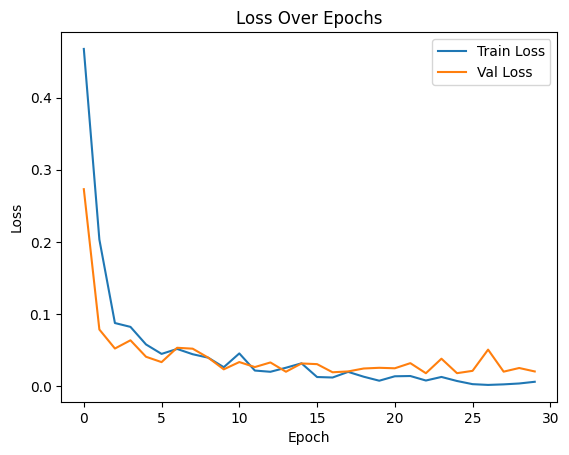

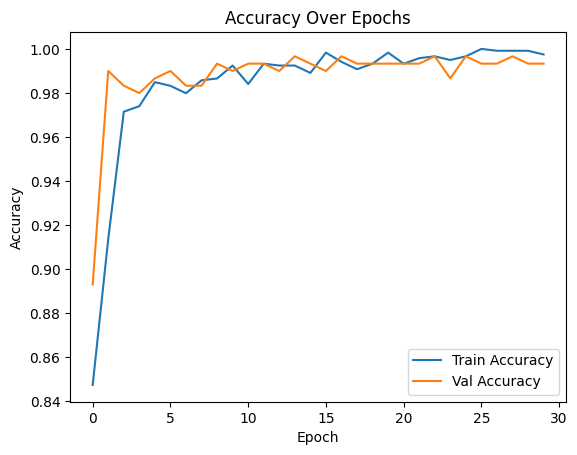

In [80]:
#Plot training history
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss curves
plt.figure()
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.figure()
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [82]:
#prepared test dataset

format_df = pd.read_csv(FORMAT_CSV)
# Make sure the ID column is treated as strings (for file name construction)
test_ids = format_df['ID'].astype(str)

# Initialize lists to hold the loaded+processed arrays and their IDs
x_test = []
id_list = []

for id_str in test_ids:
    path = os.path.join(TEST_DIR, f'{id_str}.npy')
    x = np.load(path)
    x = normalize(x)
    x = np.expand_dims(x, axis=-1)  # (72,48,1)
    x_test.append(x)
    id_list.append(id_str)

# Convert the list of samples into a single NumPy array of dtype float32
x_test = np.array(x_test, dtype=np.float32)


In [84]:
#Generate predictions on the test set
pred_probs = model.predict(x_test, batch_size=16)
pred_labels = np.argmax(pred_probs, axis=1)

# Build a submission DataFrame with IDs and predicted targets
submission = pd.DataFrame({
    'ID': id_list,
    'target': pred_labels
})

# Sort submission to match original test format
submission = submission.set_index('ID').loc[test_ids].reset_index()

# Save
out_path = os.path.join(ROOT_PATH, 'submission_v8.csv')
submission.to_csv(out_path, index=False)
print('Saved submission file to:', out_path)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Saved submission file to: /content/drive/MyDrive/ML_Project/MPA-MLF_DATA_NEW/submission_v8.csv
